In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import model_utils
from data_frame import getDataFrame
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# First 100 catagories
train_df = getDataFrame()
train_df = train_df[:5850]

In [3]:
train_df

,image_id,image_dir,category,genus
0,00000__001,../herbarium-2022-fgvc9/train_images/000/00/00...,0,0
1,00000__002,../herbarium-2022-fgvc9/train_images/000/00/00...,0,0
2,00000__003,../herbarium-2022-fgvc9/train_images/000/00/00...,0,0
3,00000__004,../herbarium-2022-fgvc9/train_images/000/00/00...,0,0
4,00000__005,../herbarium-2022-fgvc9/train_images/000/00/00...,0,0
...,...,...,...,...
5845,00100__026,../herbarium-2022-fgvc9/train_images/001/00/00...,100,21
5846,00100__027,../herbarium-2022-fgvc9/train_images/001/00/00...,100,21
5847,00100__029,../herbarium-2022-fgvc9/train_images/001/00/00...,100,21
5848,00100__030,../herbarium-2022-fgvc9/train_images/001/00/00...,100,21


In [4]:
BATCH = 16
EPOCHS = 10
LR = 0.01
IM_SIZE = 224

Transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.CenterCrop(666),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

alter_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.RandomAffine(degrees=(-180, 180), translate=(0.15, 0.3)),
    transforms.CenterCrop(666),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [5]:
def split_indices(n, val_pct=0.25, seed=99):
    n_val = int(val_pct*n)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]



In [6]:
X_Train, Y_Train = train_df['image_dir'].values, train_df['genus'].values
train_indices, val_indices = split_indices(len(X_Train))


class GetData(Dataset):
    def __init__(self, FNames, Labels, Transform):
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels         
        
    def __len__(self):
        return len(self.fnames)

    # Returns the tensor image and corresponding label in a tuple
    def __getitem__(self, index):       
        #x = Image.open(self.fnames[index])
        x = cv2.imread(self.fnames[index])
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        mask = cv2.inRange(x, (165,155,115),(255,255,255))
        x[mask>0] = (0,0,0)
        if "train" in self.fnames[index]:             
            return self.transform(x), self.labels[index]
        elif "test" in self.fnames[index]:            
            return self.transform(x), self.fnames[index]


                
trainset1 = GetData(X_Train[train_indices], Y_Train[train_indices], Transform)
trainset2 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)
trainset3 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)
trainset4 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)

trainset = trainset1 + trainset2 + trainset3 + trainset4
valset = GetData(X_Train[val_indices], Y_Train[val_indices], Transform)

print(len(trainset) + len(valset))

val_dl = DataLoader(valset, batch_size=BATCH, shuffle=True)
train_dl = DataLoader(trainset, batch_size=BATCH, shuffle=True)
print(len(val_dl), len(train_dl))
print(46*32+549*32)

19014
92 1097
19040


images.shape: torch.Size([16, 3, 224, 224])
tensor([ 8, 14,  1,  1, 14,  3,  2, 14,  0, 14,  1,  6, 10,  6, 21,  1])


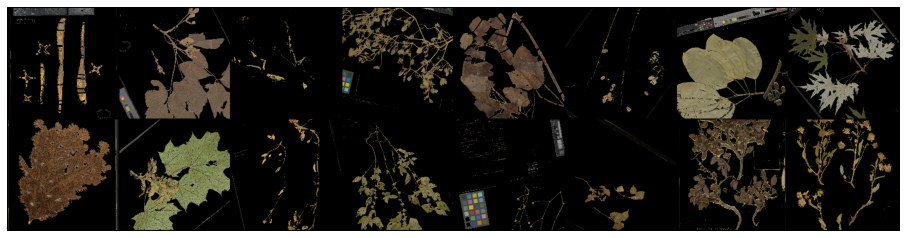

In [8]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    print(labels)
    break

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
N_Classes = train_df['genus'].nunique()

# model = torchvision.models.densenet169(pretrained = True)


# n_inputs = model.classifier.in_features
# last_layer = nn.Linear(n_inputs, N_Classes)
# model.classifier = last_layer

model = torch.load('./genus.pth')
model.to(device)
    
optimizer = torch.optim.Adam(model.parameters(), LR)
criterion = nn.CrossEntropyLoss()

In [10]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

from tqdm import tqdm

def train(trainloader, model, criterion, optimizer, scaler, device=torch.device(device)):
    train_acc = 0.0
    train_loss = 0.0
    model.train()
    for images, labels in tqdm(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = model(images)
            loss = criterion(output, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        acc = ((output.argmax(dim=1) == labels).float().mean())
        train_acc += acc
        train_loss += loss
        del output
        del loss
        
    # Decay LR by a factor of 0.1 every 2 epochs
    exp_lr_scheduler.step()
    return train_acc/len(trainloader), train_loss/len(trainloader)

def evaluate(testloader, model, criterion, device=torch.device(device)):
    eval_acc = 0.0
    eval_loss = 0.0
    model.eval()
    for images, labels in tqdm(val_dl):
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            output = model(images)
            loss = criterion(output, labels)

        acc = ((output.argmax(dim=1) == labels).float().mean())
        eval_acc += acc
        eval_loss += loss
        del output
        del loss
  
    return eval_acc/len(testloader), eval_loss/len(testloader)

In [10]:
# Load model if found in CWD
# from os.path import exists
# path_to_file = './processimg.pth'
# file_exists = exists(path_to_file)
# checkpoint = torch.load(path_to_file) if file_exists else None

# if checkpoint:
#     model.load_state_dict(checkpoint['state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer'])
#     print(f'Checkpoint has evaluation accuracy: {checkpoint["saved_accuracy"]}')
    

RuntimeError: Error(s) in loading state_dict for DenseNet:
	size mismatch for classifier.weight: copying a param with shape torch.Size([101, 1664]) from checkpoint, the shape in current model is torch.Size([22, 1664]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([101]) from checkpoint, the shape in current model is torch.Size([22]).

In [11]:
%%time
##%dirsrmal Training
scaler = torch.cuda.amp.GradScaler(enabled=True)
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, 2, 0.1)
for epoch in range(EPOCHS):
    train_acc, train_loss = train(train_dl, model, criterion, optimizer, scaler, device=device)
    torch.save(model, './genus_maskbackground.pth')
    eval_acc, eval_loss = evaluate(val_dl, model, criterion, device=device)
    print("")
    print(f"Epoch {epoch + 1} | Train Acc: {train_acc*100} | Train Loss: {train_loss}")
    print(f"\t Val Acc: {eval_acc*100} | Val Loss: {eval_loss}")
    print("===="*8)

100%|██████████| 92/92 [00:37<00:00,  2.45it/s]



Epoch 1 | Train Acc: 49.82338333129883 | Train Loss: 1.5369144678115845
	 Val Acc: 55.276268005371094 | Val Loss: 1.3556889295578003


 44%|████▍     | 480/1097 [09:41<12:02,  1.17s/it]

torch.Size([11, 3, 224, 224])

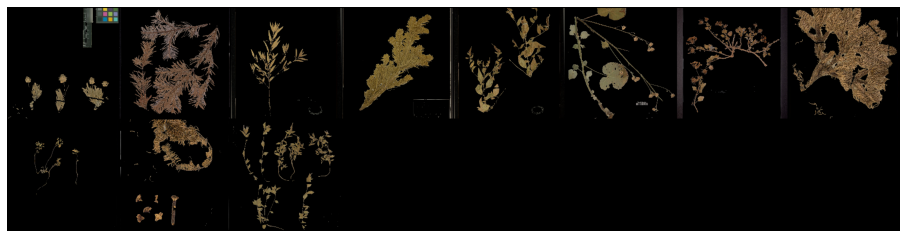

In [ ]:
for images, labels in val_dl:
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        output = model(images)
    break

images = images[output.argmax(dim=1) != labels].cpu()

plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
images.shape